<a href="https://colab.research.google.com/github/aadityakhant/fakeNewsDetection/blob/main/CNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import csv
import numpy as np
import keras as k
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
embeddings_dict = {}
with open("./drive/MyDrive/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
words = embeddings_dict.keys()

In [ ]:
class DataGenerator(k.utils.Sequence):
    def __init__(self,list_IDs, embeddings_dict):
        self.list_IDs = list_IDs
        self.embeddings_dict = embeddings_dict
        self.words = self.embeddings_dict.keys()
        self.one_hot_encoding = np.eye(4)
        self.classes = {'fake':0, 'clickbait':1, 'valid':2, 'bias':3}
        #self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs)

    #def on_epoch_end(self):
        #np.random.shuffle(self.list_IDs)

    def __getitem__(self, index):
        # Generate data
        x1 = np.empty((500,15,50))
        x2 = np.empty((500,1600,50))
        y = np.empty((500,4))
        with open(self.list_IDs[index], 'r', encoding='latin-1') as file:
          reader = csv.reader(file)
          for i, row in enumerate(file):
            r = row[:-1].split(',')

            title = r[0].split()
            if len(title)<=15:
              title = [self.embeddings_dict[t] if t in self.words else np.zeros(50) for t in title]
              title = np.pad(title, ((0,15-len(title)),(0,0)))
            else:
              title = [self.embeddings_dict[t] if t in self.words else np.zeros(50) for t in title[:15]]
            x1[i] = title

            content = r[1].split()
            if len(content)<=1600:
              content = [self.embeddings_dict[t] if t in self.words else np.zeros(50) for t in content]
              content = np.pad(content, ((0,1600-len(content)),(0,0)))
            else:
              content = [self.embeddings_dict[t] if t in self.words else np.zeros(50) for t in content[:1600]]
            x2[i] = content

            y[i] = self.one_hot_encoding[self.classes[r[2]]]

        return (x1, x2), y

In [ ]:
#input_title
title_input = k.layers.Input(shape=(15,50,), name='title_input')

x = k.layers.Bidirectional(k.layers.LSTM(23))(title_input)

#input_content
content_input = k.layers.Input(shape=(1600,50,), name='content_input')
x2 = k.layers.Bidirectional(k.layers.LSTM(150))(content_input)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(73, activation='relu')(x)
x = k.layers.Dropout(0.1)(x)
x = k.layers.Dense(24, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(k.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_input (InputLayer)    [(None, 15, 50)]             0         []                            
                                                                                                  
 content_input (InputLayer)  [(None, 1600, 50)]           0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 46)                   13616     ['title_input[0][0]']         
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 300)                  241200    ['content_input[0][0]']   

In [ ]:
train_generator = DataGenerator(['./drive/MyDrive/data2/pickle-'+str(i)+'.csv' for i in range(360)], embeddings_dict)
valid_generator = DataGenerator(['./drive/MyDrive/data2/pickle-'+str(i)+'.csv' for i in range(360,380)], embeddings_dict)
test_generator = DataGenerator(['./drive/MyDrive/data2/pickle-'+str(i)+'.csv' for i in range(380,400)], embeddings_dict)

In [ ]:
log = model.fit(train_generator, validation_data = valid_generator, epochs=10)

Epoch 1/10
360/360 [==============================] - 490s 1s/step - loss: 0.9032 - acc: 0.6172 - val_loss: 0.7077 - val_acc: 0.7095
Epoch 2/10
360/360 [==============================] - 295s 819ms/step - loss: 0.6759 - acc: 0.7258 - val_loss: 0.6198 - val_acc: 0.7423
Epoch 3/10
360/360 [==============================] - 296s 821ms/step - loss: 0.6014 - acc: 0.7570 - val_loss: 0.5842 - val_acc: 0.7536
Epoch 4/10
360/360 [==============================] - 295s 818ms/step - loss: 0.5860 - acc: 0.7712 - val_loss: 0.5500 - val_acc: 0.7686
Epoch 5/10
360/360 [==============================] - 297s 822ms/step - loss: 0.5261 - acc: 0.7907 - val_loss: 0.5324 - val_acc: 0.7822
Epoch 6/10
360/360 [==============================] - 296s 820ms/step - loss: 0.4954 - acc: 0.8047 - val_loss: 0.5089 - val_acc: 0.7960
Epoch 7/10
360/360 [==============================] - 303s 842ms/step - loss: 0.4622 - acc: 0.8185 - val_loss: 0.4990 - val_acc: 0.8035
Epoch 8/10
360/360 [==============================]

In [ ]:
model.save("./drive/MyDrive/LSTM-model.keras")

In [ ]:
model.evaluate(test_generator)

20/20 [==============================] - 15s 551ms/step - loss: 0.4600 - acc: 0.8288


[0.4600471258163452, 0.8288000226020813]

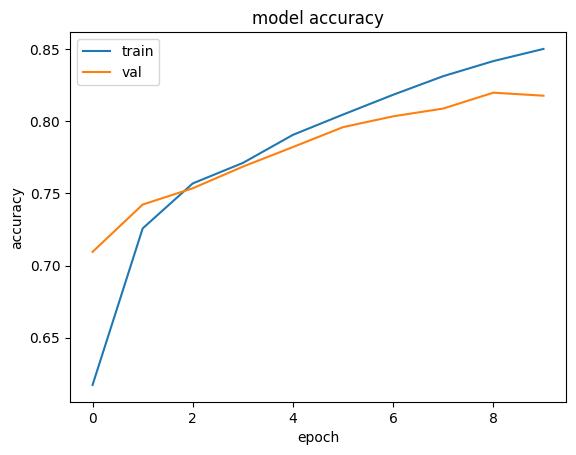

In [ ]:
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = np.empty((10000, 4))
y_true = np.empty((10000, 4))
x1 = np.empty((500, 15, 50))
x2 = np.empty((500, 1600, 50))
for i in range(20):
  (x1, x2), y_true[500*i:(500*i)+500] = test_generator.__getitem__(i)
  y_pred[500*i:(500*i)+500] = model.predict([x1,x2])

In [ ]:
y_p = [np.argmax(i) for i in y_pred]
y_t = [np.argmax(i) for i in y_true]

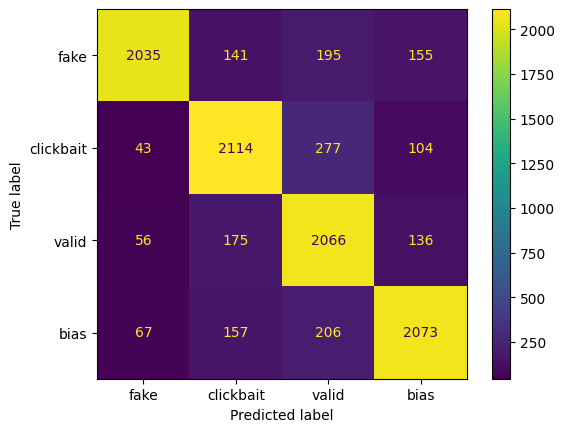

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_t, y_p), display_labels=test_generator.classes).plot()
plt.show()

In [ ]:
print(classification_report(y_pred=y_p, y_true=y_t))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2526
           1       0.82      0.83      0.82      2538
           2       0.75      0.85      0.80      2433
           3       0.84      0.83      0.83      2503

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [ ]:
#input_title
title_input = k.layers.Input(shape=(15,50,), name='title_input')

x = k.layers.Conv1D(filters = 5, kernel_size=4, strides=2, activation='relu', name='Conv1Title')(title_input)
x = k.layers.MaxPool1D(pool_size = 2, name='Pool1Title')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='relu', name='Dense1Title', kernel_regularizer='l2')(x)

#input_content
content_input = k.layers.Input(shape=(1600,50,), name='content_input')
x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu', name='Conv2Content')(content_input)
x2 = k.layers.MaxPool1D(pool_size = 4, name='Pool2Content')(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2', name='Dense1Content')(x2)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(4, activation='softmax')(x)

model = k.models.Model(inputs=[title_input, content_input], outputs=[out])
model.compile(k.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['acc'])


In [ ]:
log = model.fit(train_generator, validation_data = valid_generator, epochs=10)
model.save("./drive/MyDrive/CNN-model.keras")

Epoch 1/10
360/360 [==============================] - 605s 2s/step - loss: 1.0821 - acc: 0.6158 - val_loss: 0.8019 - val_acc: 0.6935
Epoch 2/10
360/360 [==============================] - 211s 587ms/step - loss: 0.7583 - acc: 0.7214 - val_loss: 0.7457 - val_acc: 0.7229
Epoch 3/10
360/360 [==============================] - 209s 581ms/step - loss: 0.6814 - acc: 0.7646 - val_loss: 0.7173 - val_acc: 0.7445
Epoch 4/10
360/360 [==============================] - 209s 580ms/step - loss: 0.6271 - acc: 0.7929 - val_loss: 0.7148 - val_acc: 0.7531
Epoch 5/10
360/360 [==============================] - 208s 579ms/step - loss: 0.5808 - acc: 0.8158 - val_loss: 0.7223 - val_acc: 0.7551
Epoch 6/10
360/360 [==============================] - 209s 581ms/step - loss: 0.5404 - acc: 0.8343 - val_loss: 0.7094 - val_acc: 0.7632
Epoch 7/10
360/360 [==============================] - 210s 583ms/step - loss: 0.5104 - acc: 0.8466 - val_loss: 0.7345 - val_acc: 0.7582
Epoch 8/10
360/360 [==============================]

In [ ]:
test_generator = DataGenerator(['./drive/MyDrive/data2/pickle-'+str(i)+'.csv' for i in range(380,400)], embeddings_dict)
model.evaluate(test_generator)

20/20 [==============================] - 22s 1s/step - loss: 0.7483 - acc: 0.7583


[0.7483490705490112, 0.7583000063896179]

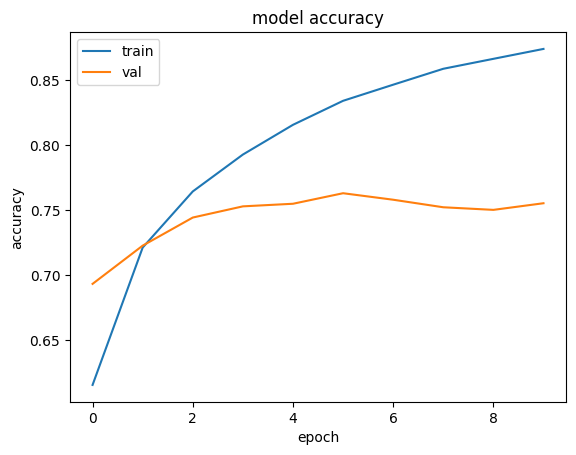

In [ ]:
plt.plot(log.history['acc'])
plt.plot(log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model = k.saving.load_model("./drive/MyDrive/CNN-model.keras")
y_pred = np.empty((10000, 4))
y_true = np.empty((10000, 4))
x1 = np.empty((500, 15, 50))
x2 = np.empty((500, 1600, 50))
for i in range(20):
  (x1, x2), y_true[500*i:(500*i)+500] = test_generator.__getitem__(i)
  y_pred[500*i:(500*i)+500] = model.predict([x1,x2])

In [ ]:
y_p = [np.argmax(i) for i in y_pred]
y_t = [np.argmax(i) for i in y_true]

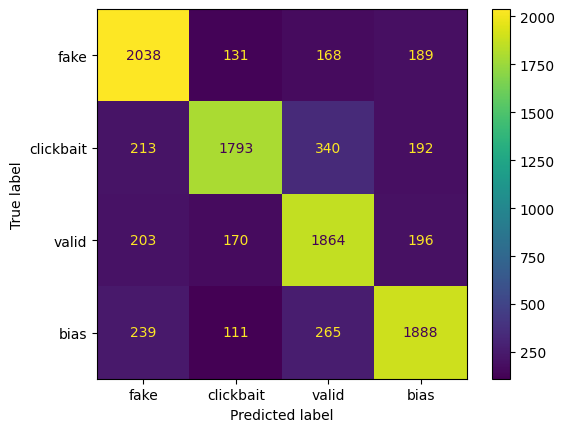

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_t, y_p), display_labels=test_generator.classes).plot()
plt.show()

In [ ]:
print(classification_report(y_pred=y_p, y_true=y_t))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      2526
           1       0.81      0.71      0.76      2538
           2       0.71      0.77      0.74      2433
           3       0.77      0.75      0.76      2503

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title_input (InputLayer)    [(None, 15, 50)]             0         []                            
                                                                                                  
 content_input (InputLayer)  [(None, 1600, 50)]           0         []                            
                                                                                                  
 Conv1Title (Conv1D)         (None, 6, 5)                 1005      ['title_input[0][0]']         
                                                                                                  
 Conv2Content (Conv1D)       (None, 397, 80)              64080     ['content_input[0][0]']       
                                                                                              